# Category_Classifier using BERT

As explained in the previous notebook, we will be trying to apply a different NLP method on our dataset, the BERT model.

First let's install the tensorflow_hub and tf-models-official libraries where will be able to extract different functions related to the BERT pre-processing model.

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 90 kB 9.1 MB/s 
     |████████████████████████████████| 211 kB 46.7 MB/s 
     |████████████████████████████████| 636 kB 50.7 MB/s 
     |████████████████████████████████| 37.1 MB 42 kB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 352 kB 50.7 MB/s 
     |████████████████████████████████| 4.4 MB 29.2 MB/s 
     |████████████████████████████████| 1.2 MB 44.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=d99cfba8185507cb72870d34d5c519b93110d83ab0a85b6dff24b30cb8ab12a3
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=6e0921762928800c0a

In [ ]:
# IMPORT

import os
import io

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving flinks-data-challenge.csv to flinks-data-challenge.csv


In [ ]:
df = pd.read_csv(io.StringIO(uploaded['flinks-data-challenge.csv'].decode('utf-8')))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.head()

,Unnamed: 0,name,goal,sub_category,main_category,launched,deadline
0,0,The Songs of Adelaide & Abullah,1000,Poetry,Publishing,2015-08-11 12:12:28,2015-10-09 11:36:00
1,1,Where is Hank?,45000,Narrative Film,Film & Video,2013-01-12 00:20:50,2013-02-26 00:20:50
2,2,ToshiCapital Rekordz Needs Help to Complete Album,5000,Music,Music,2012-03-17 03:24:11,2012-04-16 04:24:11
3,3,Community Film Project: The Art of Neighborhoo...,19500,Film & Video,Film & Video,2015-07-04 08:35:03,2015-08-29 01:00:00
4,4,Monarch Espresso Bar,50000,Restaurants,Food,2016-02-26 13:38:27,2016-04-01 13:38:27


For this model, only the name project is important and we want to make sure to have a balanced dataset so we are applying the same cleaning functions that we used in the previous notebook :

In [ ]:
def balance_datas(x):
    frames = []
    for category in x["main_category"].unique():
        df_test = x[x["main_category"] == category].sample(3000)
        frames.append(df_test)
    df_balanced = pd.concat(frames)
    return df_balanced
    
    
def cleaning_df(x):
  #Remove index column
  df_clean = x.iloc[:, 1:]

  #Sort by main_category
  df_clean = df_clean.sort_values(by="main_category")

  #Drop row with missing values
  df_clean = df_clean.dropna()

  #Balanced datas to have 3000 row for each category
  df_clean = balance_datas(df_clean)

  # Clean index and remove inconsistant features
  df_clean = df_clean.reset_index()
  df_clean = df_clean.drop(['index', 'goal', 'sub_category', 'launched', 'deadline'], axis = 1)

  return df_clean


In [ ]:
df_bert = cleaning_df(df)
df_bert.head()

,name,main_category
0,8 Little Zombies - a hardcover children's book,Art
1,Up the Witchpunx Zine Project,Art
2,The Story-Eaters Traveling Puppet Show,Art
3,The Seduction of Etain (poetry and art),Art
4,Reclaiming Vintage Hankies,Art


We than split our data into 80% train and 20% test

In [ ]:
x = df_bert.name.values
y = df_bert.main_category.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

To optimize our labelization, we are then converting our main_category into one-hot encoding values.

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

### Tokenization

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) model itself. \\
First we get the BERT model. 

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

You can see that in above cell we have loaded some variables using the bert_layer we have downloaded. 

1.   ```vocab_file``` reads the vocab file associated to the downloaded model.
2.   ```do_lower_case``` reads binary variable which if ```True``` means tokenizer will reformat all text to lower case rendering model to be not case sensitive. Should be ```False``` by default. You can check in a cell below.
3.   ```tokenizer``` builds tokenizer using variables 1 and 2.

Lastly we need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

By this point we have everything for tokenization. This will take a bit as we have quite a bit of data.

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

name = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Names shape', name.shape.as_list())

Tokenized Names shape [36000, None]


In [ ]:
name[0]

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([12685, 34850, 15835, 11162,   102], dtype=int32)>

We have an example on how the tokenizer is "tokenizing" our datas

In [ ]:
x_train[0]

'Topography Dance Film'

In [ ]:
tokenizedName = tokenizer.tokenize(x_train[0])
for i in tokenizedName:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Top [12685]
##ography [34850]
Dance [15835]
Film [11162]


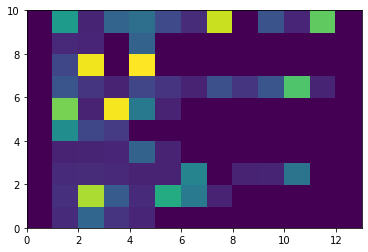

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*name.shape[0]
input_word_ids = tf.concat([cls, name], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

What you see above is a graphical representation of our tokenized name project. First token is our classification token. Other colored blocks than background are other tokens. The end background is simply padding.

## Masked and Input Types

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

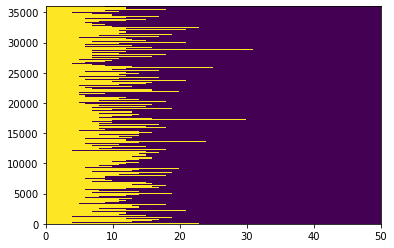

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Here each yellow block has some input. We just make this for the model to differ between padding and input.

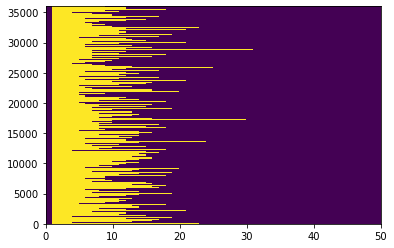

In [ ]:
type_cls = tf.zeros_like(cls)
type_name = tf.ones_like(name)
input_type_ids = tf.concat([type_cls, type_name], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

It's hard to see but we added an empty block in front of each tweet for the `[CLS]` token. Check tensor below

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into functions.

First we check the length of each name project to get the max one

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 50


To secure our model with eventually longer name in our test dataset or for more new name we rise the max value.

In [ ]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 75


In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

## MODEL 

### Training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [1]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.3)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

NameError: ignored

Set up the training parameters.

In [ ]:
epochs = 3
batch_size = 64  # selected based on our GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 75)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 75)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 75)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
563/563 [==============================] - 1158s 2s/step - loss: 1.8725 - accuracy: 0.4005 - val_loss: 1.4711 - val_accuracy: 0.5340
Epoch 2/3
563/563 [==============================] - 1133s 2s/step - loss: 1.3935 - accuracy: 0.5577 - val_loss: 1.4093 - val_accuracy: 0.5569
Epoch 3/3
563/563 [==============================] - 1129s 2s/step - loss: 1.2358 - accuracy: 0.6092 - val_loss: 1.4151 - val_accuracy: 0.5586


In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6570
Testing Accuracy:  0.5586


We can see that the BERT model improve our previous classification accuracy from 52% to 56%

However, the training and testing accuracy score is still generaly low. 

But the fact that the 2 results are close to each other make me again think that one of the problems here may be the construction of the dataset and the way the project names are assigned among all the different categories.
Indeed, I think some categories are too related to others, which can create confusion when we need to assign a project to a category. 

A next challenge could be to find the most correlated categories and create more general categories to simplify the first part of our classification, and then we could implement more specific models that could classify each project into their more specific category.

## Conclusion 

This challenge was very interested to work on. I was a little bit confused and frustrated by the fact that I coulnd't find a good solution for this problem even with some advanced methods like BERT but i think that an interesting axe of reflexion for this challenge could be to work more on the data rather than focus on the modeling part.

In any case, I hope you found my work interesting, thank you for reading it !